# Intro

Data scientists tend to focus on **prediction** because that's where conventional machine learning excels. But real world decision-making involves both prediction and **optimization**.  After predicting what will happen, you decide what to do about it.

Optimization gets less attention than it deserves. So this micro-challenge will test your optimization skills as you write a function to improve how airlines set prices.

![Imgur](https://i.imgur.com/AKrbLMR.jpg)


# The Problem

You recently started Aviato.com, a startup that helps airlines set ticket prices. 

Aviato's success will depend on a function called `pricing_function`.  This notebook already includes a very simple version of `pricing_function`.  You will modify `pricing_function` to maximize the total revenue collected for all flights in our simulated environment.

For each flight, `pricing_function` will be run once per (simulated) day to set that day's ticket price. The seats you don't sell today will be available to sell tomorrow, unless the flight leaves that day.

Your `pricing_function` is run for one flight at a time, and it takes following inputs:
- **Number of days until the flight**
- **Number of seats they have left to sell**
- **A variable called `demand_level` that determines how many tickets you can sell at any given price. **

The quantity you sell at any price is:
> quantity_sold = demand_level - price

Ticket quantities are capped at the number of seats available.

Your function will output the ticket price.

You learn the `demand_level` for each day at the time you need to make predictions for that day. For all days in the future, you only know `demand_level` will be drawn from the uniform distribution between 100 and 200.  So, for any day in the future, it is equally likely to be each value between 100 and 200.

In case this is still unclear, some relevant implementation code is shown below.

# The Simulator
We will run your pricing function in a simulator to test how well it performs on a range of flight situations.  **Run the following code cell to set up your simulation environment:**

In [1]:
import sys
sys.path.append('../input')
from flight_revenue_simulator import simulate_revenue, score_me

In case you want to check your understanding of the simulator logic, here is a simplified version of some of the key logic (leaving out the code that prints your progress). If you feel you understand the description above, you can skip reading this code.

```python
def _tickets_sold(p, demand_level, max_qty):
        quantity_demanded = floor(max(0, p - demand_level))
        return min(quantity_demanded, max_qty)

def simulate_revenue(days_left, tickets_left, pricing_function, rev_to_date=0, demand_level_min=100, demand_level_max=200):
    if (days_left == 0) or (tickets_left == 0):
        return rev_to_date
    else:
        demand_level = uniform(demand_level_min, demand_level_max)
        p = pricing_function(days_left, tickets_left, demand_level)
        q = _tickets_sold(demand_level, p, tickets_left)
        return _total_revenue(days_left = days_left-1, 
                              tickets_left = tickets_left-q, 
                              pricing_function = pricing_function, 
                              rev_to_date = rev_to_date + p * q,
                              demand_level_min = demand_level_min,
                              demand_level_max = demand_level_max
                             )
```

# Your Code

Here is starter code for the pricing function.  If you use this function, you will sell 10 tickets each day (until you run out of tickets).

In [2]:
def pricing_function(days_left, tickets_left, demand_level):
    """Sample pricing function"""
    price = demand_level - 10
    return price

To see a small example of how your code works, test it with the following function:

In [3]:
simulate_revenue(days_left=7, tickets_left=50, pricing_function=pricing_function, verbose=True)

7 days before flight: Started with 50 seats. Demand level: 158. Price set to $148. Sold 10 tickets. Daily revenue is 1476. Total revenue-to-date is 1476. 40 seats remaining
6 days before flight: Started with 40 seats. Demand level: 104. Price set to $94. Sold 10 tickets. Daily revenue is 939. Total revenue-to-date is 2415. 30 seats remaining
5 days before flight: Started with 30 seats. Demand level: 148. Price set to $138. Sold 10 tickets. Daily revenue is 1382. Total revenue-to-date is 3797. 20 seats remaining
4 days before flight: Started with 20 seats. Demand level: 118. Price set to $108. Sold 10 tickets. Daily revenue is 1079. Total revenue-to-date is 4876. 10 seats remaining
3 days before flight: Started with 10 seats. Demand level: 109. Price set to $99. Sold 10 tickets. Daily revenue is 991. Total revenue-to-date is 5867. 0 seats remaining
This flight is booked full.
Total Revenue: $5867


5867.13239094882

You can try simulations for a variety of values.

Once you feel good about your pricing function, run it with the following cell to to see how it performs on a wider range of flights.

# Intro

This is my solution to the [Airline Price Optimization Micro-Challenge](https://www.kaggle.com/dansbecker/airline-price-optimization-micro-challenge) and is based on [Dan's solution](https://www.kaggle.com/dansbecker/airline-price-optimization-solution).

***I've vectorized the implementation to run faster and I've made a couple of changes described bellow, this changes beated the baseline score from \\$7,558 to $7,607.***


---

# Strategy

This solution uses an optimization technique called **dynamic programming**.  **Dynamic programming** starts by solving an optimization problem in a very limited scenario, and then creates an iterative rule to expand to larger problem.

In our case, we first solve for the optimal price when you only have 1 day to sell tickets before the flight.  Then we continually step back to longer time-horizons one day at a time.

This solution highlights two of the most important ideas from the fields of dynamic programming and reinforcement learning.  
- The **value function** returns the best outcome achievable from any input state.  In our case, **V(tickets_left, days_left)** returns the best revenue you can expect to achieve given the number of tickets you have and the number of days left before the flight.
-  The **Q Function** is similar to the value function. But it includes your decision as an input, and it returns the expected revenue even if that is not based on an optimal decision policy.

The distinction may become clearer when you see it in practice below. 

The output of the Q function for **T+1** days before the flight depends how much revenue is the sum of 
- revenue from flights sold that day
- revenue earned in the last **T** days from the remaining tickets.

Daily revenue is straightforward to calculate (as you'll see below.)  Since we calculate **Q** and the value function (denoted **V**) start near flight time, and then iteratively work backwards, we can look up revenue from the last **T** days from the value function.

Once we have **Q** at time T+1,  we calculate **V** on that day by looking up the revenue associated with the best decision from **Q**.

Again, this should become clearer as you see it in code.

# The Base Case: Selling Tickets For a Single Day

You want to maximize revenue, given the knowledge that 
> quantity_sold = demand_level - price

You may want to keep the price high rather than sell all remaining tickets. So, this problem is not as trivial as finding the price to sell all available tickets.  Instead, you will go back to find the price and quantity pair that maximize 
> revenue = price * quantity_sold

It's easier to think about optimization in terms of a single choice variable, rather than using an equation that explicitly includes both `price` and `quantity_sold`. To do this, first rearrange the `quantity_sold` equation above with simple algebra to solve for price:
> price = demand_level - quantity_sold

Plug this expression for price into the revenue equation and you have
> revenue = (demand_level - quantity_sold) * quantity_sold

*note: you could also express revenue entirely in terms of price instead of quantity, but would make a later steps a little messier.

Since `demand_level` is just a known number when you make your daily price decisions, you can plot revenue as an equation that depends only on the quantity you sell. 

For the sake of an example, here is the plot when `demand_level` is 200.

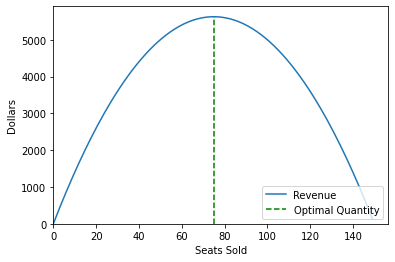

In [4]:
import matplotlib.pyplot as plt
import numpy as np

demand_level = 150
# only plot quantities up to demand_level. That's point where price becomes 0
revenue = [(demand_level - q) * q for q in range(demand_level)]

# Make primary plot
plt.plot(revenue, label="Revenue")
plt.xlabel("Seats Sold")
plt.ylabel("Dollars")
plt.ylim(ymin=0)
plt.xlim(xmin=0)

# Show the revenue maximizing quantity
optimal_q = np.argmax(revenue)
plt.vlines(x=optimal_q, ymin=0, ymax=max(revenue), color='green', linestyle="--", label="Optimal Quantity")

plt.legend(loc='lower right')
plt.show()

# Setting Up Q and V
Since the inputs to the V and Q functions take a limited number of values, we can store these function outputs in numpy arrays, indexed by the inputs. 

We'll include the `demand_level` as an input to Q, since that will affect your decision.  In practice, we use V to look up potential revenue for future days, and we won't know `demand_level` on those days when we do the lookup.  So, instead we will take an "expected value" by averaging over the future revenue from a range of demand levels.  For simplicity, we discretize the possible demand levels, calculating from a set of evenly spread values.

Here is the set-up code:

***Note: Avoiding the discretization the score improves from \\$7,558 to $7,582.***

In [5]:
%%time
n_demand_levels = 101
min_demand_level = 100
max_demand_level = 200
demand_levels = np.linspace(min_demand_level, max_demand_level, n_demand_levels)

max_tickets = 201
max_days = 150

# Q indices are: n_sold in day, tickets_left to start day, demand_level, days_left
Q = np.zeros([max_tickets, max_tickets, n_demand_levels, max_days])
# V indices are: n_left and n_days
V = np.zeros([max_tickets, max_days])

CPU times: user 489 µs, sys: 0 ns, total: 489 µs
Wall time: 366 µs


# The Base Case: Selling With One Day Left
We then fill in Q values with `revenue = price * tickets_sold`.  Since this is the last day before the flight, we don't need to worry about future values.

The code for V is a little trickier than Q. So it is explained in the code comments.

In [6]:
%%time
for tickets_left in range(max_tickets):
    # add 1 to offset 0 indexing. Allow selling all tickets
    for tickets_sold in range(tickets_left+1):
        Q[tickets_sold, tickets_left, :, 0] = np.maximum(demand_levels - tickets_sold, 0) * tickets_sold
    # For each demand_level, choose the optimum number to sell. Output of this is array .of size n_demand_levels
    revenue_from_best_quantity_at_each_demand_level = Q[:, tickets_left, :, 0].max(axis=0)
    # take the average, since we don't know demand level ahead of time and all are equally likely
    V[tickets_left, 0] = revenue_from_best_quantity_at_each_demand_level.mean()

CPU times: user 739 ms, sys: 1.72 s, total: 2.46 s
Wall time: 2.46 s


# The General Case: Solving for Other Time Horizons
Now we iteratively calculate V and Q for time periods further back.  

The Q function now calculates current revenue as you saw above, but then adds the **V** of leftover tickets.

***Note: I've fixed the code to make it possible to sell all tickets even before the last day. This change improves the score from \\$7,558 to $7,569.***

In [7]:
%%time
for days_left in range(1, max_days):
    for tickets_left in range(max_tickets):
        # add 1 to offset 0 indexing. Allow selling all tickets
        for tickets_sold in range(tickets_left+1):
            Q[tickets_sold, tickets_left, :, days_left] = np.maximum(demand_levels - tickets_sold, 0) * tickets_sold + V[tickets_left - tickets_sold, days_left - 1]
                
        expected_total_rev_from_best_quantity_at_each_demand_level = Q[:, tickets_left, :, days_left].max(axis=0)
        V[tickets_left, days_left] = expected_total_rev_from_best_quantity_at_each_demand_level.mean()

CPU times: user 29.1 s, sys: 10.6 ms, total: 29.1 s
Wall time: 29.1 s


We have **Q** and **V**.  How do we use them?

For any given number of tickets, days_left and demand_level, we look in **Q** to find the number of tickets with the highest Q-value.

Here is our pricing function that implements that:

In [8]:
def pricing_function(days_left, tickets_left, demand_level):
    demand_level_index = np.abs(demand_level - demand_levels).argmin()
    day_index = days_left - 1 # arrays are 0 indexed
    tickets_index = int(tickets_left)  # in case it comes in as float, but need to index with it
    relevant_Q_vals = Q[:, tickets_index, demand_level_index, day_index]
    desired_quantity = relevant_Q_vals.argmax()# offset 0 indexing
    price = demand_level - desired_quantity
    return price

And here is the score:

In [9]:
score_me(pricing_function)

Ran 200 flights starting 100 days before flight with 100 tickets. Average revenue: $18515
Ran 200 flights starting 14 days before flight with 50 tickets. Average revenue: $8567
Ran 200 flights starting 2 days before flight with 20 tickets. Average revenue: $2913
Ran 200 flights starting 1 days before flight with 3 tickets. Average revenue: $434


<IPython.core.display.Javascript object>

Average revenue across all flights is $7607


# Discuss
Want to discuss your solution or hear what others have done?  There is a [discussion thread](https://www.kaggle.com/general/62469) just for you.

---
*This micro-challenge is from an exercise in an upcoming Optimization course on **[Kaggle Learn](https://www.kaggle.com/Learn?utm_medium=website&utm_source=kaggle.com&utm_campaign=micro+challenge+2018)**.  If you enjoyed this challenge and want to beef up your data science skills, you might enjoy our other courses.*